# ***Key-Frames Generator***

In [1]:
!pip install peakutils
import os
import cv2
import csv
import numpy as np
import time
import peakutils
import matplotlib.pyplot as plt
from PIL import Image
import shutil


In [2]:


def scale(img, xScale, yScale):
    res = cv2.resize(img, None, fx=xScale, fy=yScale, interpolation=cv2.INTER_AREA)
    return res


def crop(infile, height, width):
    im = Image.open(infile)
    imgwidth, imgheight = im.size
    for i in range(imgheight // height):
        for j in range(imgwidth // width):
            box = (j * width, i * height, (j + 1) * width, (i + 1) * height)
            yield im.crop(box)


def averagePixels(path):
    r, g, b = 0, 0, 0
    count = 0
    pic = Image.open(path)
    for x in range(pic.size[0]):
        for y in range(pic.size[1]):
            imgData = pic.load()
            tempr, tempg, tempb = imgData[x, y]
            r += tempr
            g += tempg
            b += tempb
            count += 1
    return (r / count), (g / count), (b / count), count

def convert_frame_to_grayscale(frame):
    grayframe = None
    gray = None
    if frame is not None:
        cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = scale(gray, 1, 1)
        grayframe = scale(gray, 1, 1)
        gray = cv2.GaussianBlur(gray, (9, 9), 0.0)
    return grayframe, gray

def prepare_dirs(keyframePath, imageGridsPath, csvPath):
    if not os.path.exists(keyframePath):
        os.makedirs(keyframePath)
    if not os.path.exists(imageGridsPath):
        os.makedirs(imageGridsPath)
    if not os.path.exists(csvPath):
        os.makedirs(csvPath)


def plot_metrics(indices, lstfrm, lstdiffMag):
    plt.plot(indices, y[indices], "x")
    l = plt.plot(lstfrm, lstdiffMag, 'r-')
    plt.xlabel('frames')
    plt.ylabel('pixel difference')
    plt.title("Pixel value differences from frame to frame and the peak values")
    plt.show()

In [3]:
def keyframeDetection(dest, Thres, plotMetrics=False, verbose=False):
    
    keyframePath = dest+'/keyFrames'
    imageGridsPath = dest+'/imageGrids'
    csvPath = dest+'/csvFile'
    path2file = csvPath + '/output.csv'
    prepare_dirs(keyframePath, imageGridsPath, csvPath)

    cap = cv2.VideoCapture('tmp.mp4')
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  
    if (cap.isOpened()== False):
        print("Error opening video file")

    lstfrm = []
    lstdiffMag = []
    timeSpans = []
    images = []
    full_color = []
    lastFrame = None
    Start_time = time.process_time()
    fps = cap.get(cv2.CAP_PROP_FPS)
    def timestamp(frame_number):
      return float(frame_number)/fps
    # Read until video is completed
    for i in range(length):
        ret, frame = cap.read()
        grayframe, blur_gray = convert_frame_to_grayscale(frame)

        frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES) - 1
        lstfrm.append(frame_number)
        images.append(grayframe)
        full_color.append(frame)
        if frame_number == 0:
            lastFrame = blur_gray

        diff = cv2.subtract(blur_gray, lastFrame)
        diffMag = cv2.countNonZero(diff)
        lstdiffMag.append(diffMag)
        stop_time = time.process_time()
        time_Span = stop_time-Start_time
        timeSpans.append(time_Span)
        lastFrame = blur_gray

    cap.release()
    y = np.array(lstdiffMag)
    base = peakutils.baseline(y, 2)
    indices = peakutils.indexes(y-base, Thres, min_dist=1)
    
    ##plot to monitor the selected keyframe
    if (plotMetrics):
        plot_metrics(indices, lstfrm, lstdiffMag)

    cnt = 1
    for x in indices:
        cv2.imwrite(os.path.join(keyframePath , 'keyframe'+ str(timestamp(x)) +'.jpg'), full_color[x])
        cnt +=1
        log_message = 'keyframe ' + str(cnt) + ' happened at ' + str(timeSpans[x]) + ' sec.'
        if(verbose):
            print(log_message)
        with open(path2file, 'w') as csvFile:
            writer = csv.writer(csvFile)
            writer.writerows(log_message)
            csvFile.close()

    cv2.destroyAllWindows()

In [4]:

import argparse


def keyframegenerator():
    dir = '/content/drive/MyDrive/Colab Notebooks/dest'
    if os.path.exists(dir):
      shutil.rmtree(dir)
    os.makedirs(dir)
    threshold=0.3  #Threshold defines how much one image can differ from another on the scale of 0 to 1
    keyframeDetection(dir, float(threshold)) 


keyframegenerator()

# ***YoloV3 Object Detection***

In [5]:
# -----------------------------------------Object Detection------------------------------------------------

import struct
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from numpy import expand_dims

In [6]:
# define the model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/yolov3.h5')

In [7]:
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [8]:
IMAGE_WIDTH=416
IMAGE_HEIGHT=416
def load_and_preprocess_image(path,shape):
  image=tf.io.read_file(path)
  width,height=load_img(path).size
  image=tf.image.decode_jpeg(image,channels=3)
  image=tf.image.resize(image, shape)
  image/=255
  return image,width,height

In [9]:
class BoundBox:
	'''
	Objects of boxes. (xmin,ymin) represents the upleft coordinate of the box while (xmax,ymax) means downright one.
	'''
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			objectness = netout[int(row)][int(col)][b][4]
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height

			# last elements are class probabilities
      
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

In [10]:
def box_filter(boxes,labels,threshold_socre):
	valid_boxes=[]
	valid_labels=[]
	valid_scores=[]
	for box in boxes:
		for i in range(len(labels)):
			if box.classes[i] > threshold_socre:
				valid_boxes.append(box)
				valid_labels.append(labels[i])
				valid_scores.append(box.classes[i])
		
	return (valid_boxes,valid_labels,valid_scores)

In [17]:
def detect_obj(filename, valid_data):
  data = pyplot.imread(filename)
  pyplot.imshow(data)
  ax = pyplot.gca()
  print("Object   Accuracy")
  for i in range(len(valid_data[0])):
    box = valid_data[0][i]
    y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, fill=False, color='white')
    ax.add_patch(rect)
    print(valid_data[1][i],"    ", valid_data[2][i])
    label = "%s (%.3f)" % (valid_data[1][i], valid_data[2][i])
    pyplot.text(x1, y1, label, color='white')
  pyplot.show()

In [18]:
def encoder_dic(valid_data):
  data_dic={}
  (valid_boxes,valid_labels,valid_scores)=valid_data
  for box, label,score in zip(valid_boxes,valid_labels,valid_scores):
    if label not in data_dic:
      data_dic[label]=[[score,box,'kept']]
    else:
      data_dic[label].append([score,box,'kept'])
      
  return data_dic

In [19]:
def decode_box_coor(box):
  return (box.xmin, box.ymin,box.xmax, box.ymax )

def iou(box1, box2):
  (box1_x1, box1_y1, box1_x2, box1_y2) = decode_box_coor(box1)
  (box2_x1, box2_y1, box2_x2, box2_y2) = decode_box_coor(box2)

  xi1 = max(box1_x1,box2_x1)
  yi1 = max(box1_y1,box2_y1)
  xi2 = min(box1_x2,box2_x2)
  yi2 = min(box1_y2,box2_y2)
  inter_width = xi2-xi1
  inter_height = yi2-yi1
  inter_area = max(inter_height,0)*max(inter_width,0)

  box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
  box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
  union_area = box1_area+box2_area-inter_area 

  iou = inter_area/union_area
  
  return iou

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Object   Accuracy
person      0.815428
car      0.82859004
person      0.6238393
person      0.9870893
car      0.9592131
car      0.9680059
car      0.73616004
car      0.7439218
car      0.9743147
car      0.85372823
car      0.979342


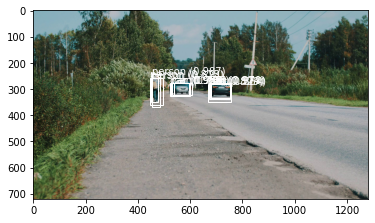

In [20]:
#-----------------------------------expirement------------------------------------------------#
photo_filename='/content/drive/MyDrive/Colab Notebooks/keyframe0.3333333333333333.jpg'
_image, image_w, image_h=load_and_preprocess_image(photo_filename,[IMAGE_WIDTH,IMAGE_HEIGHT])
plt.imshow(_image)
image = expand_dims(_image, 0)
yhat = model.predict(image)
print([a.shape for a in yhat])
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
boxes = list()
for i in range(len(yhat)):
	boxes += decode_netout(yhat[i][0], anchors[i], net_h=IMAGE_HEIGHT, net_w=IMAGE_WIDTH)

for i in range(len(boxes)):
	x_offset, x_scale = (IMAGE_WIDTH - IMAGE_WIDTH)/2./IMAGE_HEIGHT, float(IMAGE_WIDTH)/IMAGE_WIDTH
	y_offset, y_scale = (IMAGE_HEIGHT - IMAGE_HEIGHT)/2./IMAGE_HEIGHT, float(IMAGE_HEIGHT)/IMAGE_HEIGHT
	boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
	boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
	boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
	boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
len(boxes)
valid_data= box_filter(boxes, labels, threshold_socre=0.6)
detect_obj(photo_filename,valid_data)

In [21]:
#--------------ON ORIGNAL KEY FRAMES-------------------------------------------
def showresults(path,max_box,max_path,max_object_image):
  _image,width,height=load_and_preprocess_image(path,[IMAGE_WIDTH,IMAGE_HEIGHT])
  image = expand_dims(_image, 0)
  yhat = model.predict(image)
  boxes = list()
  for i in range(len(yhat)):
	  boxes += decode_netout(yhat[i][0], anchors[i], net_h=IMAGE_HEIGHT, net_w=IMAGE_WIDTH)
  for i in range(len(boxes)):
    x_offset, x_scale = (IMAGE_WIDTH - IMAGE_WIDTH)/2./IMAGE_HEIGHT, float(IMAGE_WIDTH)/IMAGE_WIDTH
    y_offset, y_scale = (IMAGE_HEIGHT - IMAGE_HEIGHT)/2./IMAGE_HEIGHT, float(IMAGE_HEIGHT)/IMAGE_HEIGHT
    boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
    boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
    boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
    boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
  valid_data= box_filter(boxes, labels, threshold_socre=0.6)
  data_dic=encoder_dic(valid_data)
# ------------------NMS-------------------------------------------------------------------------------------------------------------#
  nms_thresh=0.5
  final_boxes,final_scores,final_labels=list(),list(),list()
  for label in data_dic:
    scores_boxes=sorted(data_dic[label],reverse=True)
    for i in range(len(scores_boxes)):
      if scores_boxes[i][2]=='removed': continue
      for j in range(i+1,len(scores_boxes)):
        if iou(scores_boxes[i][1],scores_boxes[j][1]) >= nms_thresh:
          scores_boxes[j][2]="removed"

    for e in scores_boxes:
      if e[2]=='kept':
        final_boxes.append(e[1])
        final_labels.append(label)
        final_scores.append(e[0])
  if max_box < len(final_boxes):
    max_box=len(final_boxes)
    max_object_image=(final_boxes,final_labels,final_scores)
    max_path=curr_dir
  return max_box,max_path,max_object_image

keyframe0.08333333333333333.jpg
keyframe0.20833333333333334.jpg
keyframe0.4583333333333333.jpg
keyframe0.5833333333333334.jpg
keyframe0.7083333333333334.jpg
keyframe0.8333333333333334.jpg
keyframe0.9583333333333334.jpg
keyframe1.0833333333333333.jpg
keyframe1.2083333333333333.jpg
keyframe1.3333333333333333.jpg
keyframe1.4583333333333333.jpg
keyframe3.75.jpg
keyframe7.5.jpg
Nos of object in image:- 4
File name with timestamp:- keyframe3.75.jpg


Object   Accuracy
car      0.99252546
car      0.931845
car      0.91339356
person      0.9914547


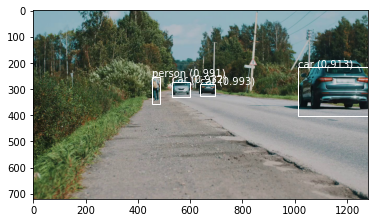

In [22]:
max_path=""
max_box=0
max_object_image=()
path = "/content/drive/MyDrive/Colab Notebooks/dest/keyFrames"
dir_list = os.listdir(path)
for i in dir_list:
  curr_dir=i
  print(i)
 
  max_box,max_path,max_object_image=showresults('/content/drive/MyDrive/Colab Notebooks/dest/keyFrames/'+curr_dir,max_box,max_path,max_object_image)
print("Nos of object in image:-",max_box)
print("File name with timestamp:-",max_path)
print("\n")
detect_obj('/content/drive/MyDrive/Colab Notebooks/dest/keyFrames/'+max_path,max_object_image)

